# Trial History Modulation

In [1]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import flow
import pool
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy as sp
import bottleneck as bt
from scipy.stats import pearsonr
from scipy.cluster import hierarchy

# except: 
import tensortools as tt
from flow.misc import wordhash
from cascade import utils
from cascade import paths
from cascade import tca
from functools import reduce

In [4]:
sorted(mice)

['OA26', 'OA27', 'OA32', 'OA34', 'OA36', 'OA67', 'VF226']

In [2]:
mice = ['OA27', 'VF226', 'OA67','OA32', 'OA34', 'OA36', 'OA26']
words = ['bookmarks']
words.extend(['horrible']*6)

# load in a full size tensor
model_list = []
tensor_list = []
id_list = []
bhv_list = []
meta_list = []
for mouse, word in zip(mice, words):
    out = cas.load.load_all_groupday(mouse, word=word, with_model=True, group_by='all3', nan_thresh=0.95)  # return   model, ids, tensor, meta, bhv
    model_list.append(out[0])
    tensor_list.append(out[2])
    id_list.append(out[1])
    bhv_list.append(out[4])
    meta_list.append(cas.utils.add_10stages_to_meta(out[3], simple=False))

Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.


In [4]:
meta_list[0].head()

orientation condition initial_condition  \
mouse date     run trial_idx                                            
OA27  170116.0 3   0                    0   neutral           neutral   
                   1                  135     minus             minus   
                   2                  270      plus              plus   
                   3                    0   neutral           neutral   
                   4                  135     minus             minus   

                              trialerror  prev_reward  prev_punish  \
mouse date     run trial_idx                                         
OA27  170116.0 3   0                 3.0        False        False   
                   1                 4.0        False        False   
                   2                 0.0        False        False   
                   3                 3.0        False        False   
                   4                 4.0        False        False   

                              prev_same_plus  prev_same_neutral  \
mouse date     run trial_idx                                      
OA27  170116.0 3   0                   False              False   
                   1                   False              False   
                   2                   False              False   
                   3                   False              False   
                   4                   False              False   

                              prev_same_minus  prev_blank  ...  \
mouse date     run trial_idx                               ...   
OA27  170116.0 3   0                    False       False  ...   
                   1                    False       False  ...   
                   2                    False       False  ...   
                   3                    False       False  ...   
                   4                    False       False  ...   

                             p_go_since_last_go p_reward_since_last_go  \
mouse date     run trial_idx                                             
OA27  170116.0 3   0                        NaN                    NaN   
                   1                        NaN                    NaN   
                   2                        NaN                    NaN   
                   3                        NaN                    NaN   
                   4                        NaN                    NaN   

                             p_initial_plus_since_last_reward  \
mouse date     run trial_idx                                    
OA27  170116.0 3   0                                      NaN   
                   1                                      NaN   
                   2                                      NaN   
                   3                                      NaN   
                   4                                      NaN   

                              p_initial_minus_since_last_reward  \
mouse date     run trial_idx                                      
OA27  170116.0 3   0                                        NaN   
                   1                                        NaN   
                   2                                        NaN   
                   3                                        NaN   
                   4                                        NaN   

                              p_initial_neutral_since_last_reward  \
mouse date     run trial_idx                                        
OA27  170116.0 3   0                                          NaN   
                   1                                          NaN   
                   2                                          NaN   
                   3                                          NaN   
                   4                                          NaN   

                              p_go_since_last_reward  \
mouse date     run trial_idx                           
OA27  170116.0 3   0                             NaN 

Mice hashed: compilation
cascade.paths: Assuming default pars: cs: '', warp: '', trace_type: zscore_day


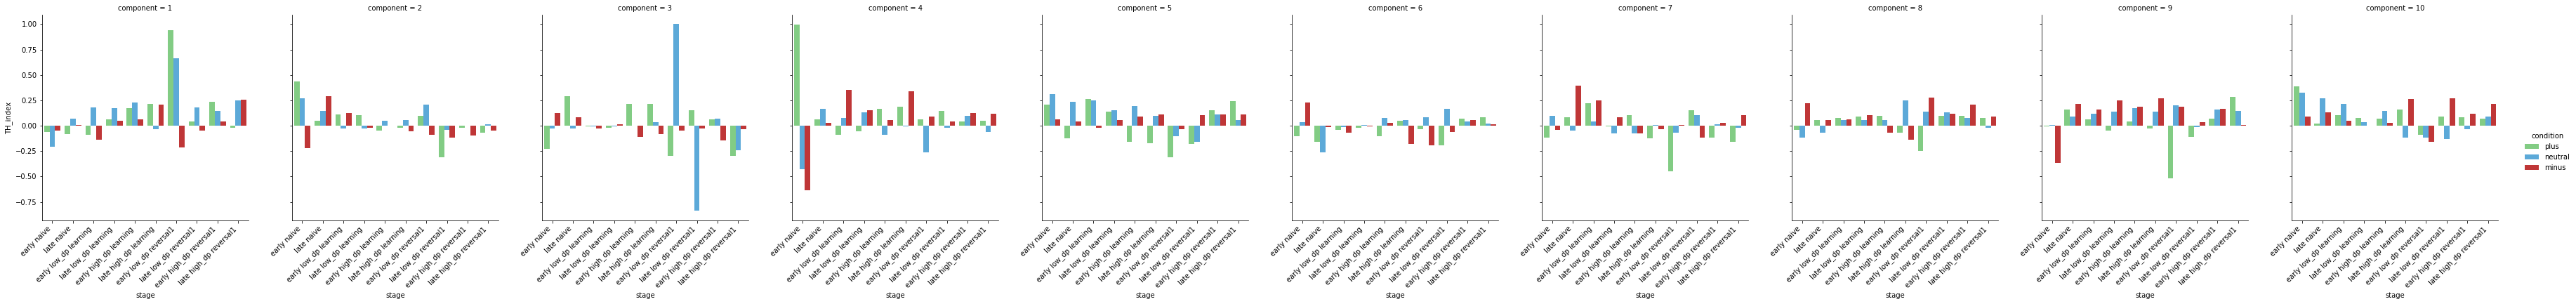

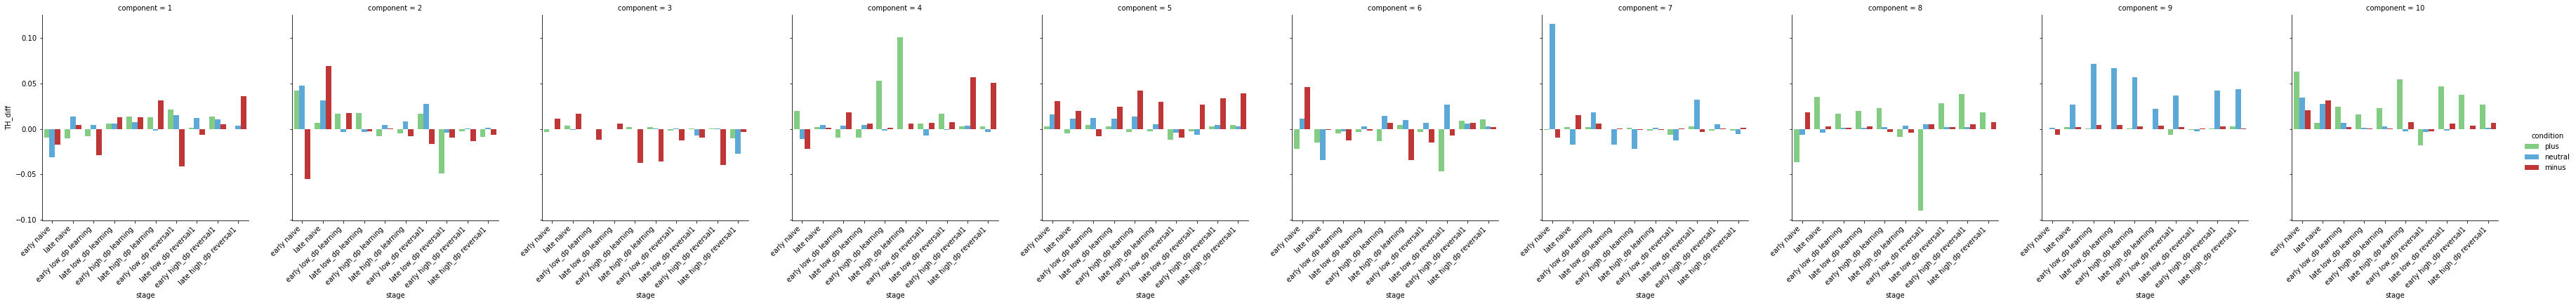

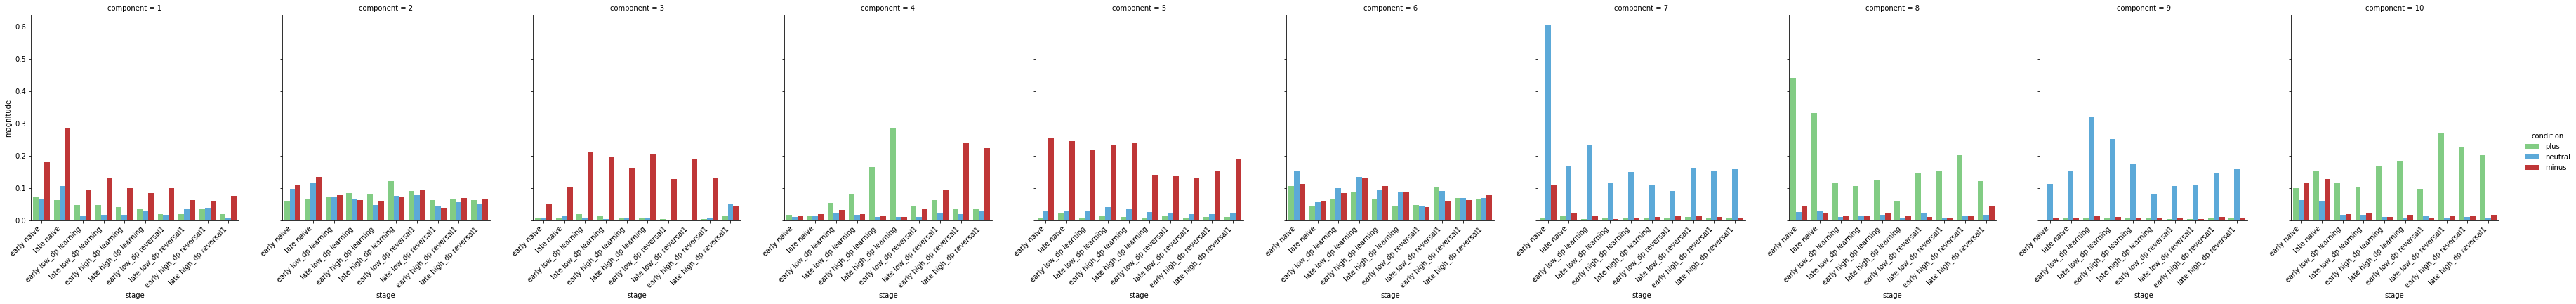

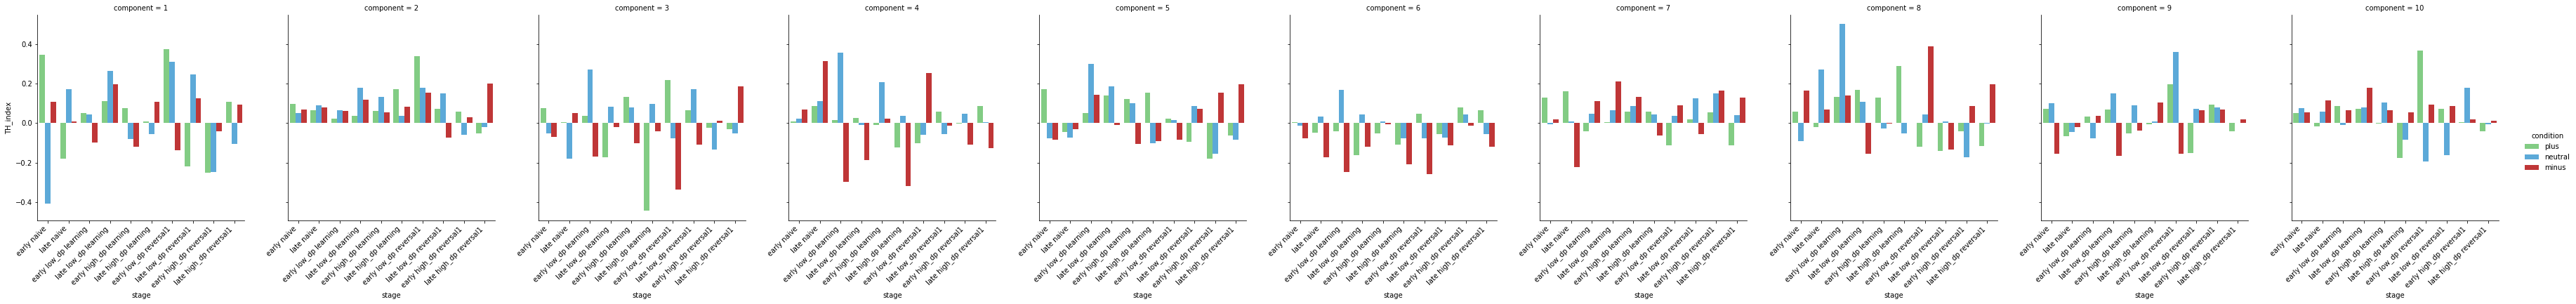

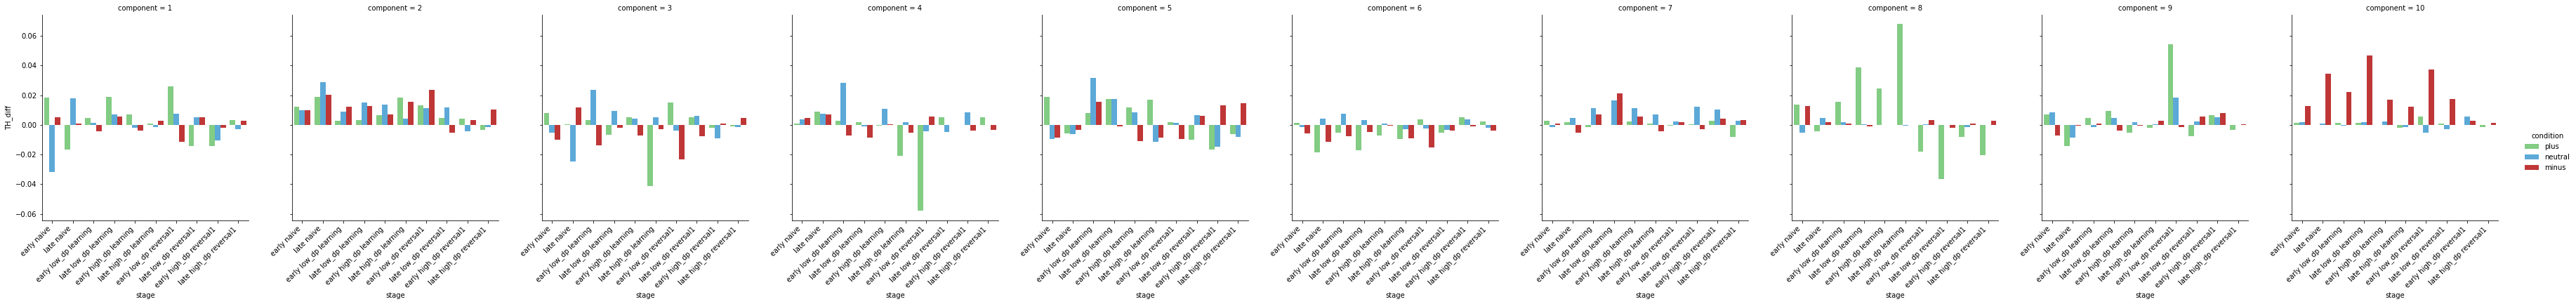

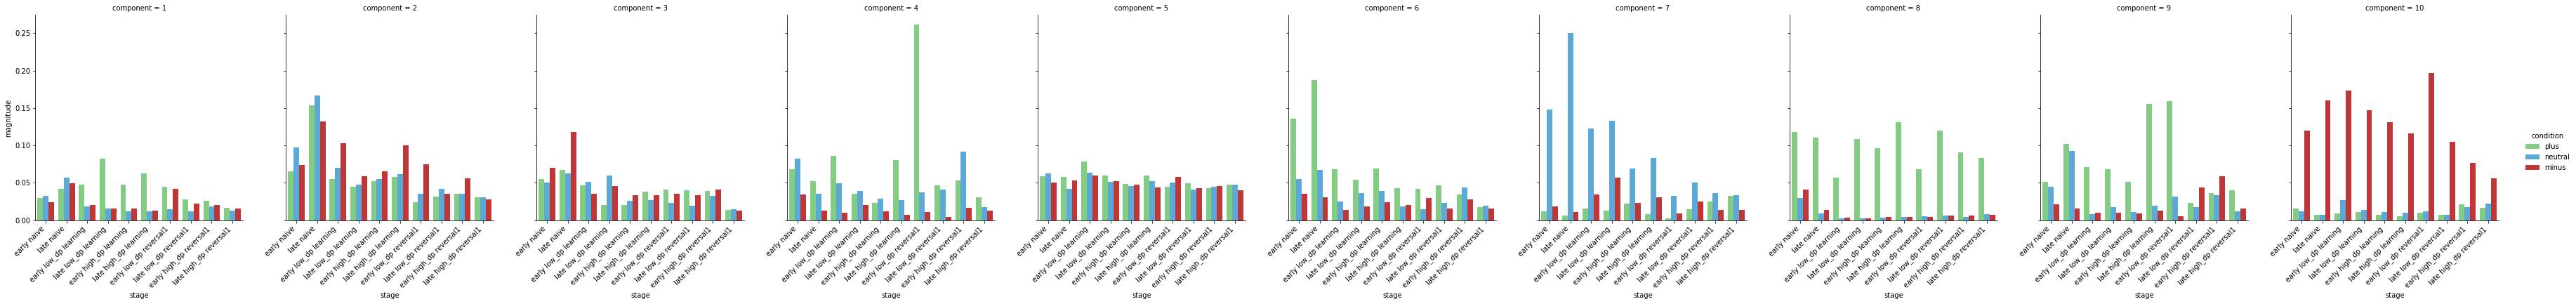

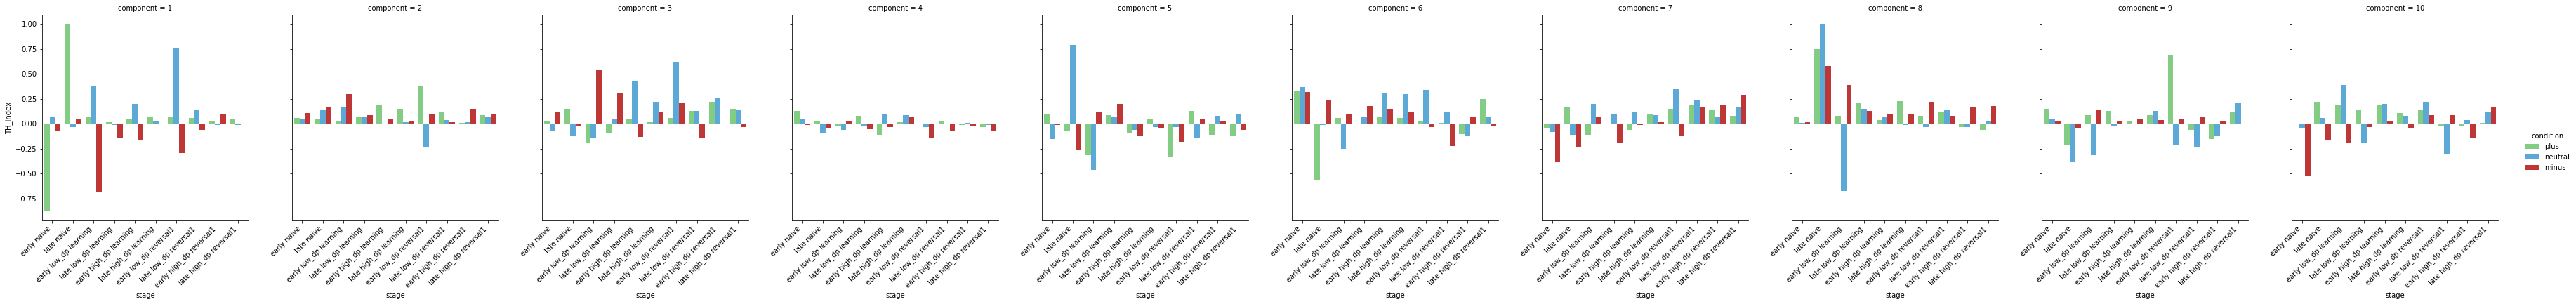

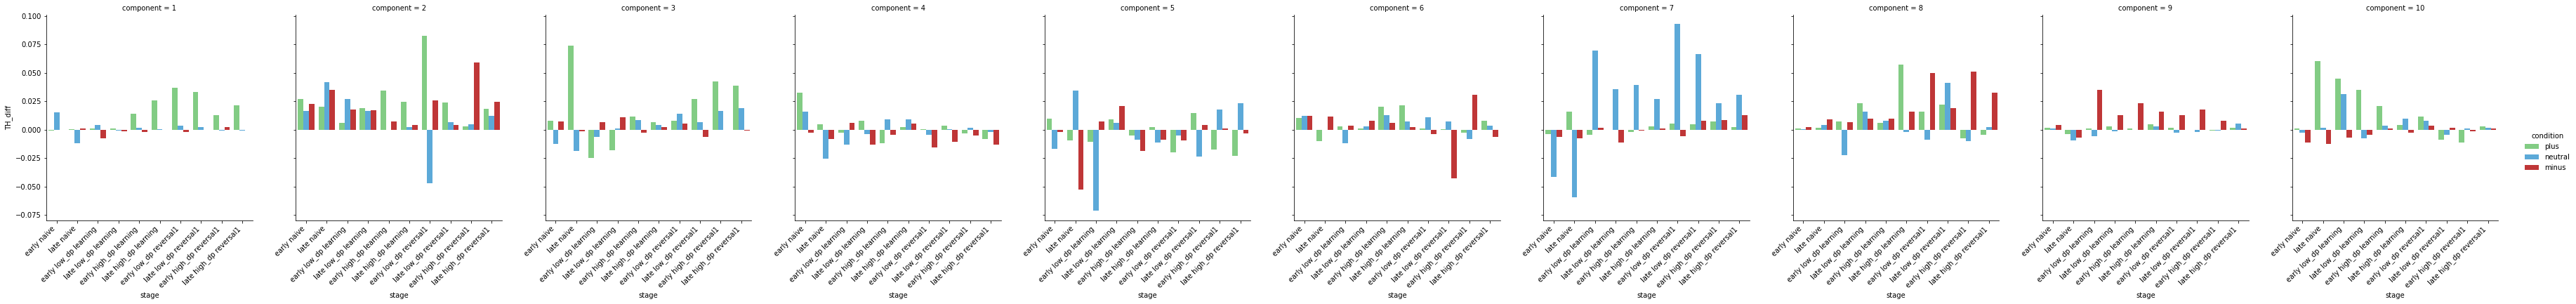

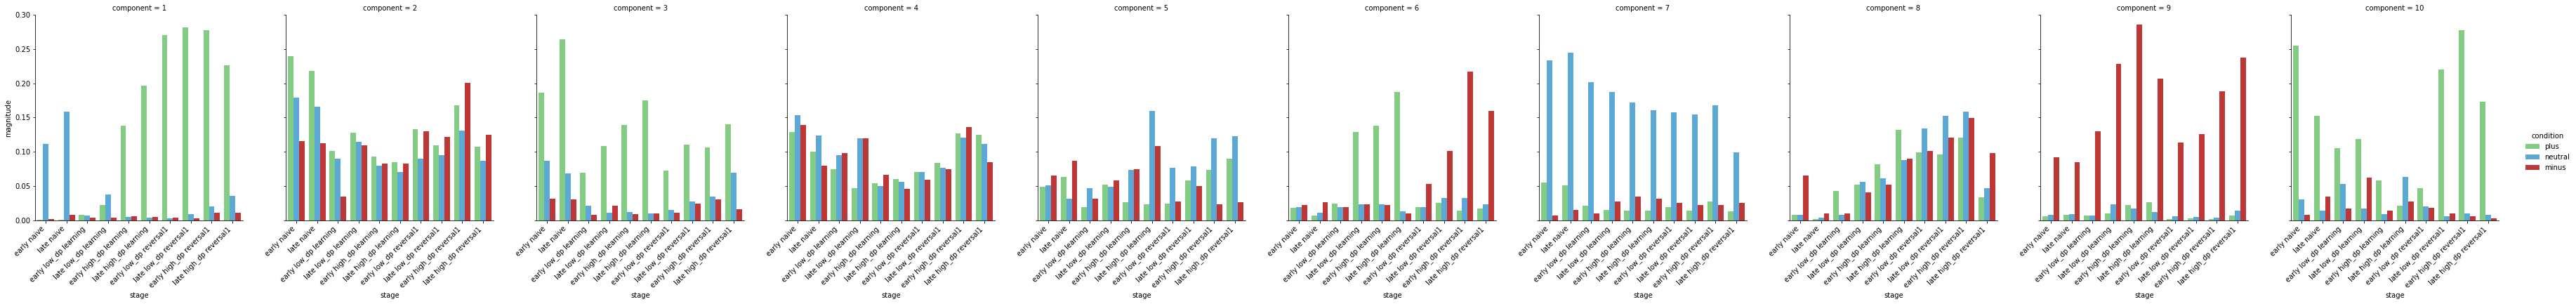

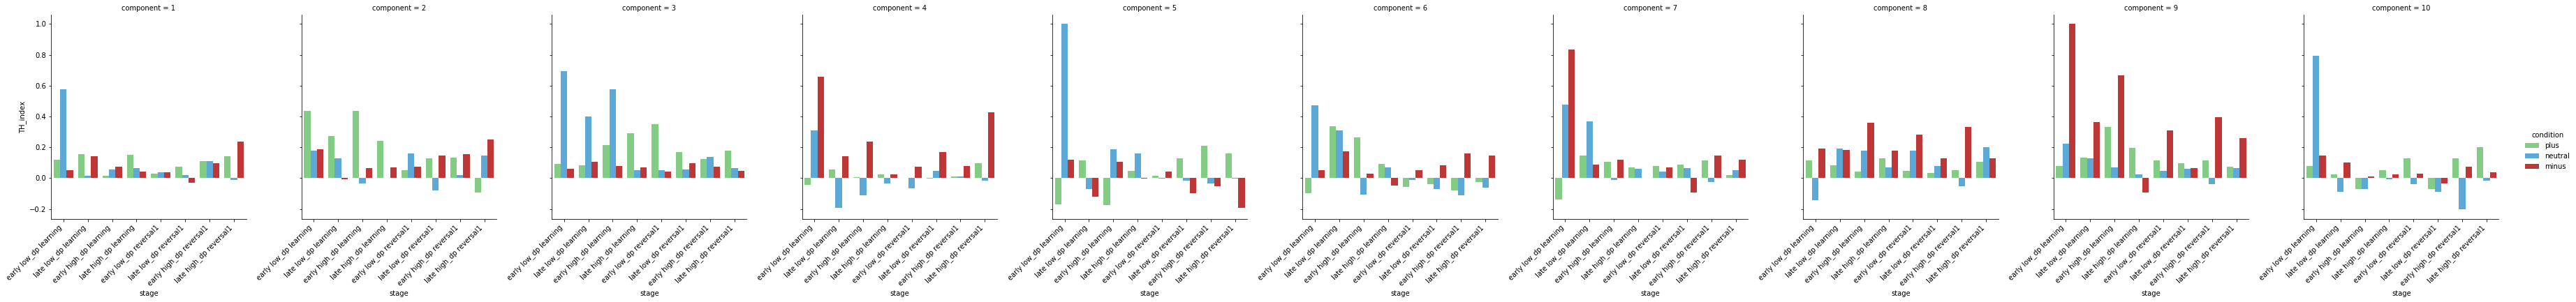

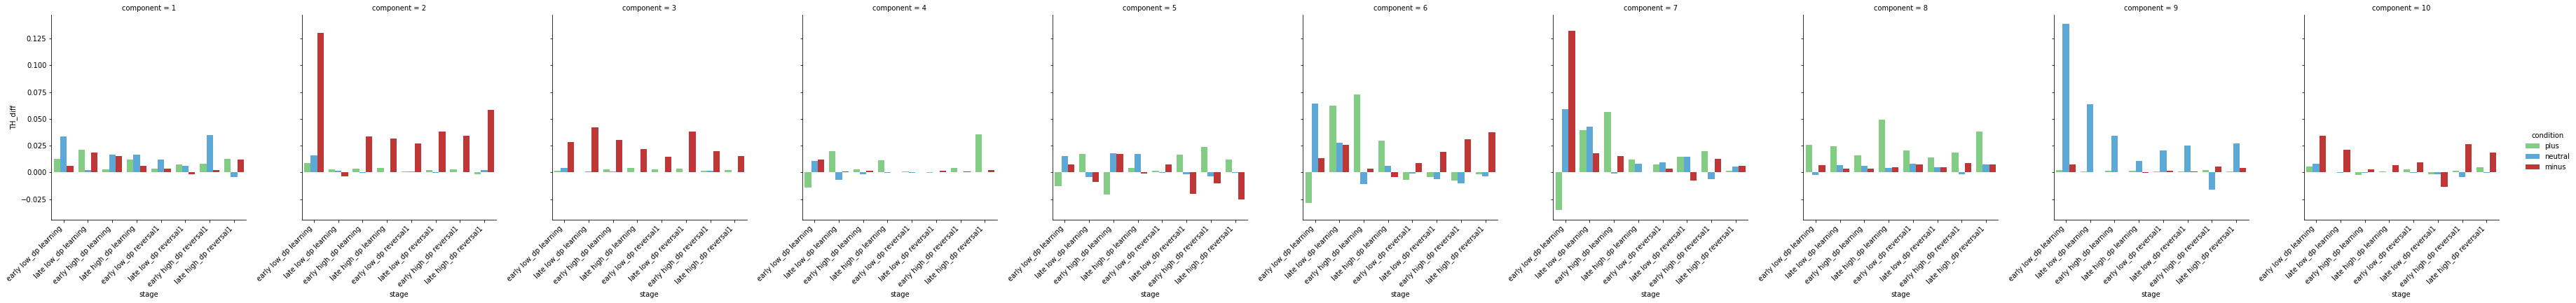

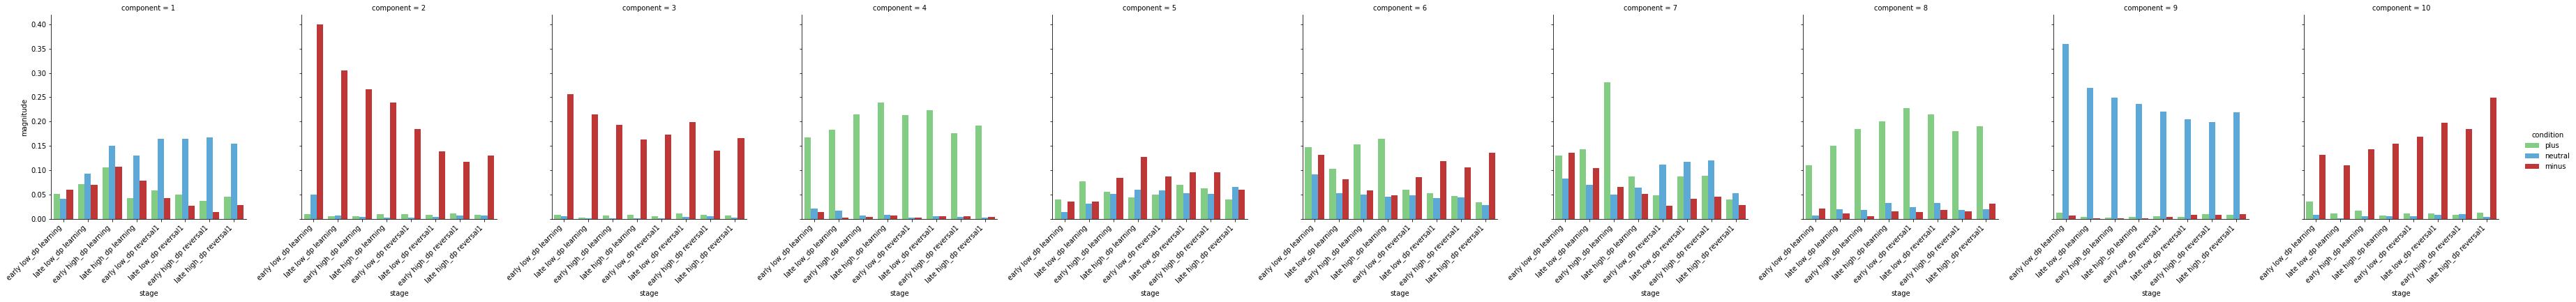

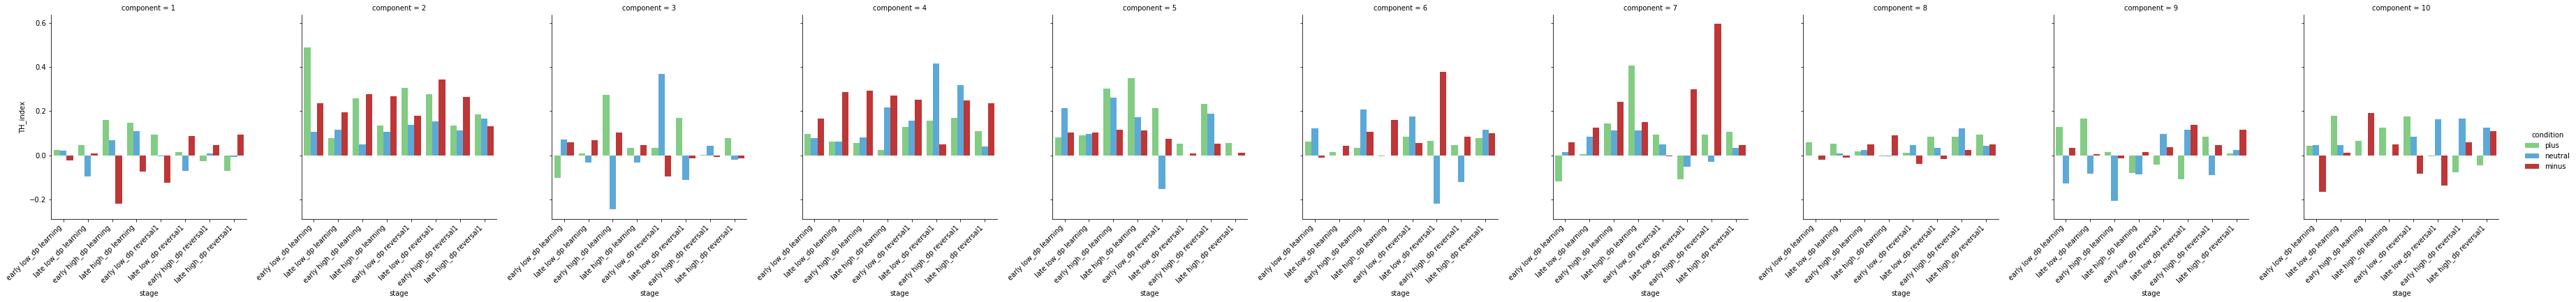

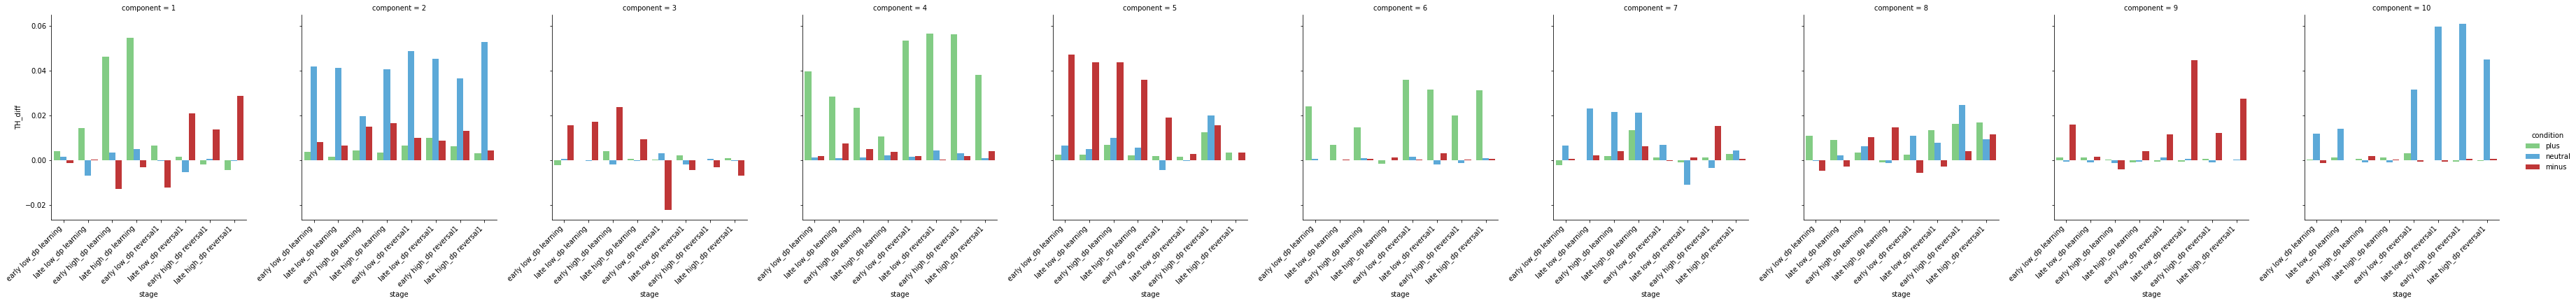

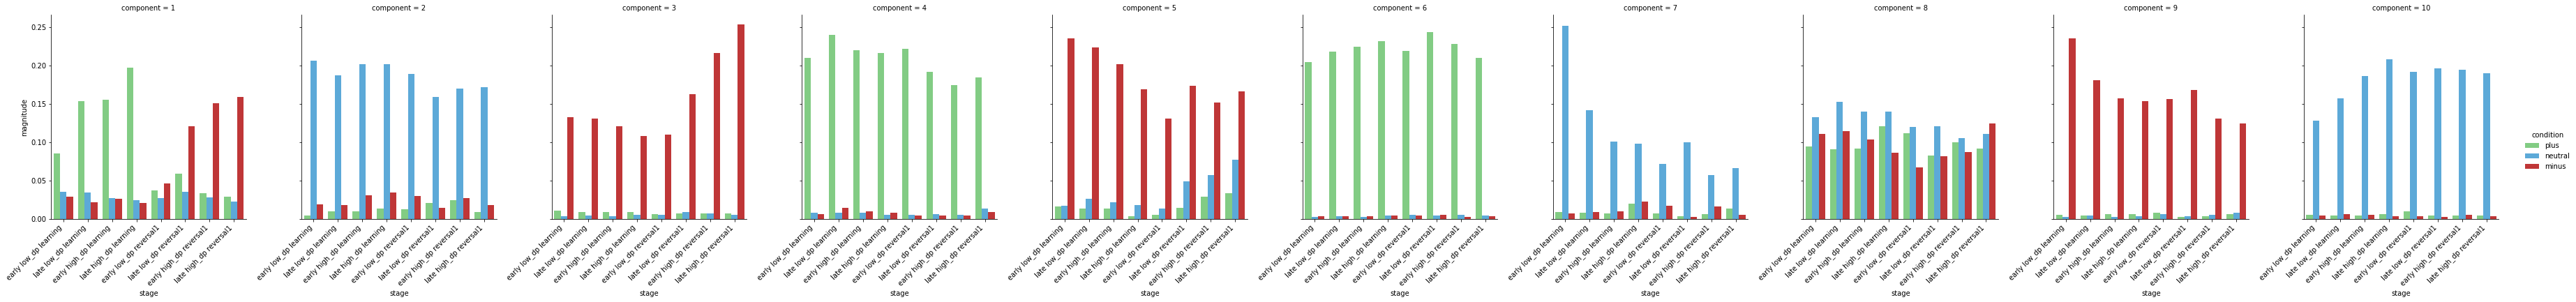

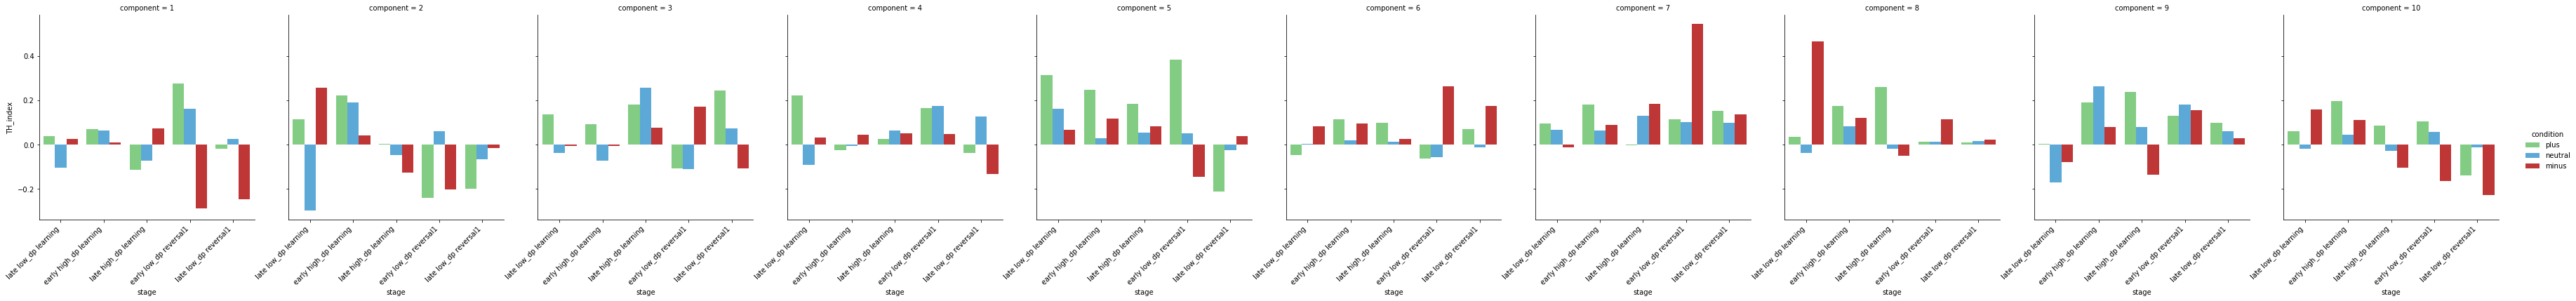

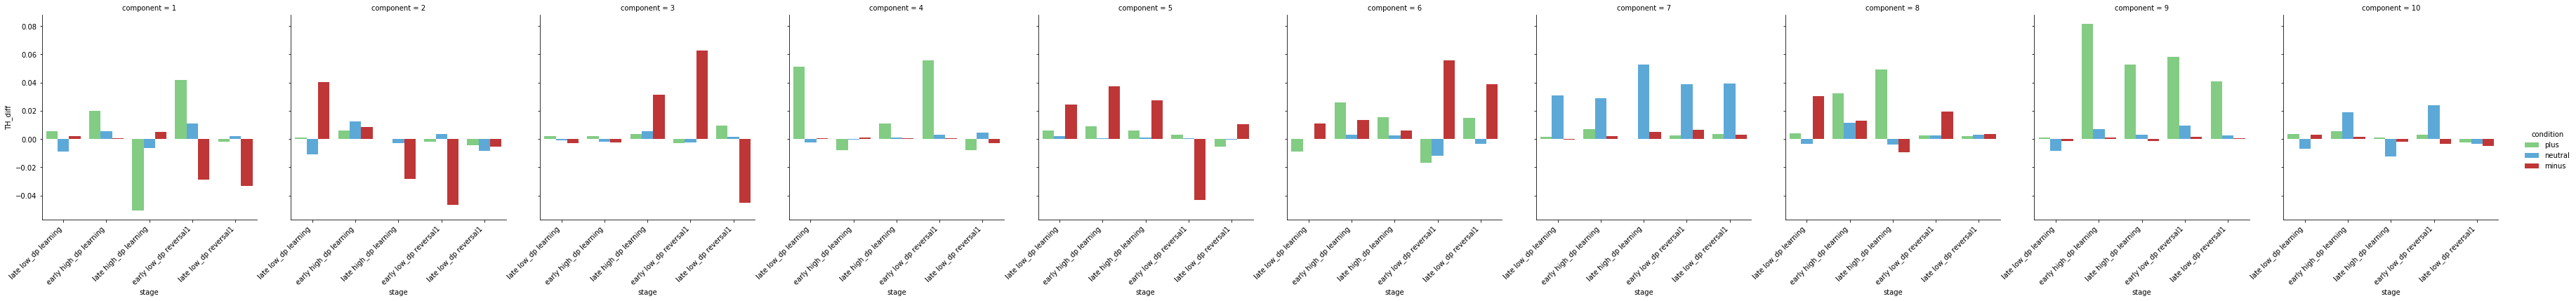

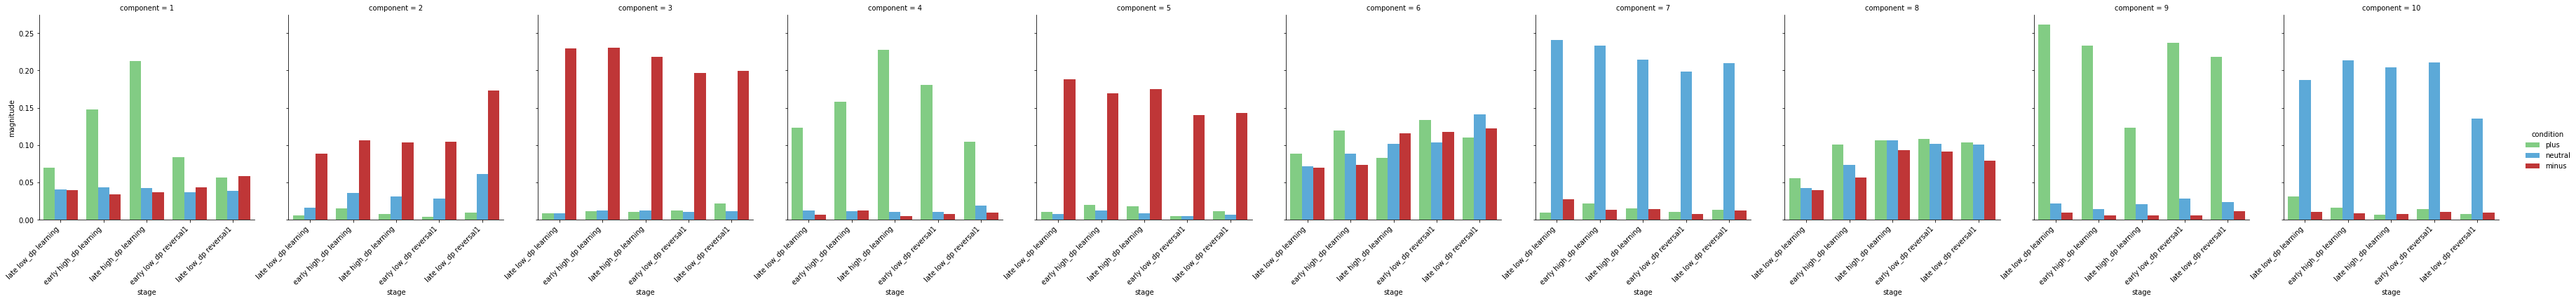

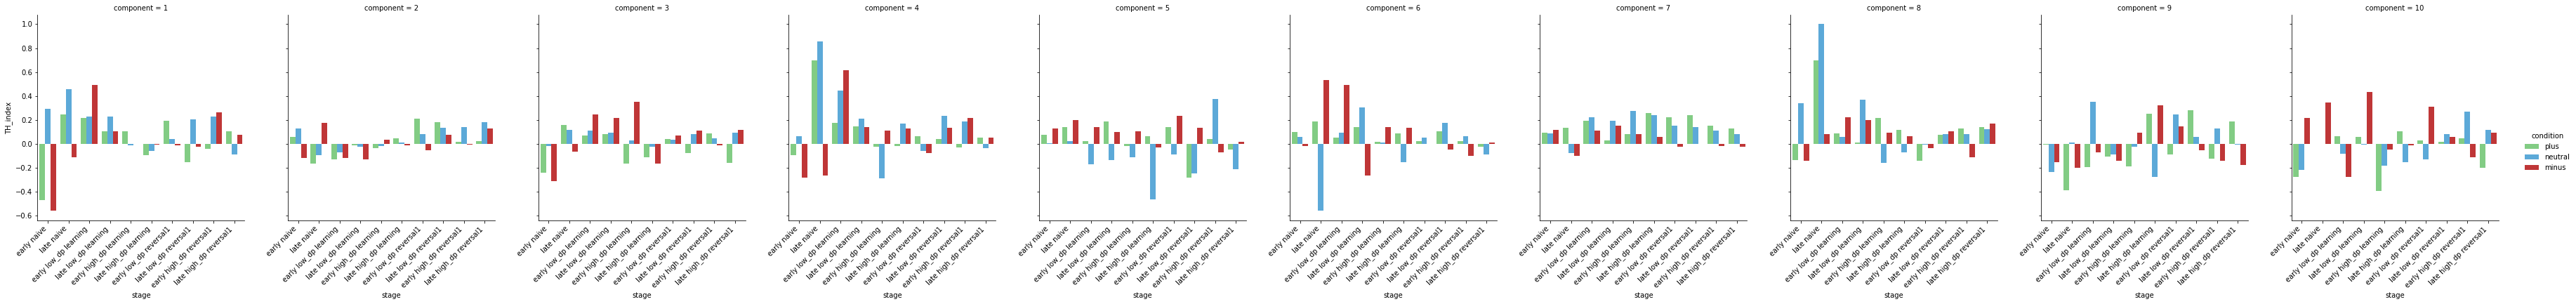

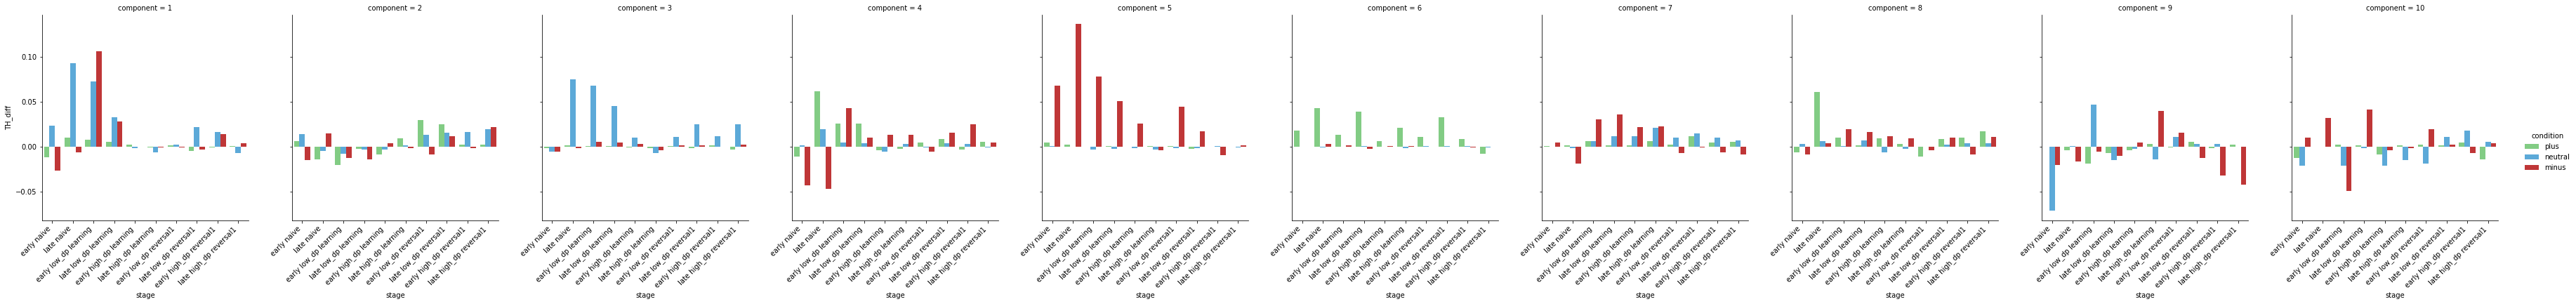

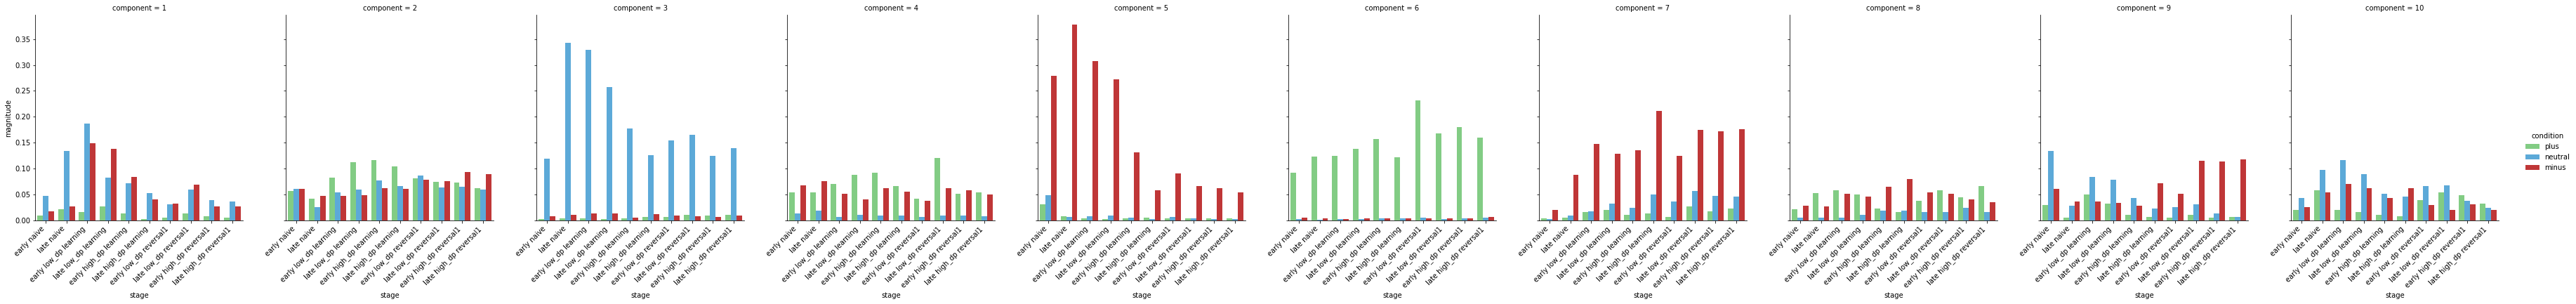

In [10]:
# m_num = 1
rank_num = 10

save_folder = cas.paths.save_dir_groupmouse(
        mice,
        'staged trial history analysis',
        method='ncp_hals',
        nan_thresh=0.85,
        score_threshold=0.95,
        pars=None,
        words=words,
        rank_num=rank_num,
        grouping='group',
        group_pars={'group_by': 'all3'})

for m_num in range(len(mice)):
    facs = model_list[m_num].results[rank_num][0].factors[2][:, :]
    col_list = meta_list[m_num]['parsed_10stage'].unique()

    # preallocate
    th_dict = {}
    for k in ['plus', 'neutral', 'minus']:
        th_dict[k] = {}
        for i in col_list:
            th_dict[k][i] = {}

    pd_list = []
    for i in col_list:
        stage_bool = meta_list[m_num]['parsed_10stage'].isin([i]).values
        for k in ['plus', 'neutral', 'minus']:
            cond_bool = meta_list[m_num]['initial_condition'].isin([k]).values
            same_prev_bool = meta_list[m_num]['prev_same_{}'.format(k)].values
            diff_prev_bool = cond_bool & ~same_prev_bool
            prev_same_stage = stage_bool & same_prev_bool
            prev_diff_stage = stage_bool & diff_prev_bool

            stage_same = np.nanmean(facs[prev_same_stage, :], axis=0)
            stage_mag = np.nanmean(facs[stage_bool & cond_bool, :], axis=0)
            stage_diff = np.nanmean(facs[prev_diff_stage, :], axis=0)
            th_dict[k][i] = [stage_same, stage_diff]

            pd_dict = {'component': range(1, len(stage_same)+1),
                       'condition': [k]*len(stage_same),
                       'stage': [i]*len(stage_same),
                       'TH_index': (stage_diff - stage_same)/(stage_same + stage_diff),
                       'TH_diff': (stage_diff - stage_same),
                       'magnitude': stage_mag
                      }
            pd_list.append(pd.DataFrame(data=pd_dict))
    df = pd.concat(pd_list, axis=0)

    g = sns.catplot(data=df, col='component', y='TH_index', hue='condition', kind='bar', x='stage', palette=cas.lookups.color_dict)
    g.set_xticklabels(rotation=45, ha='right')
    plt.savefig(os.path.join(save_folder, 'TH_index {} barplot 10stage.pdf'.format(mice[m_num])), bbox_inches='tight')
    
    g = sns.catplot(data=df, col='component', y='TH_diff', hue='condition', kind='bar', x='stage', palette=cas.lookups.color_dict)
    g.set_xticklabels(rotation=45, ha='right')
    plt.savefig(os.path.join(save_folder, 'TH_diff {} barplot 10stage.pdf'.format(mice[m_num])), bbox_inches='tight')
    
    g = sns.catplot(data=df, col='component', y='magnitude', hue='condition', kind='bar', x='stage', palette=cas.lookups.color_dict)
    g.set_xticklabels(rotation=45, ha='right')
    plt.savefig(os.path.join(save_folder, 'Magnitude TCA trial factor weight {} barplot 10stage.pdf'.format(mice[m_num])), bbox_inches='tight')

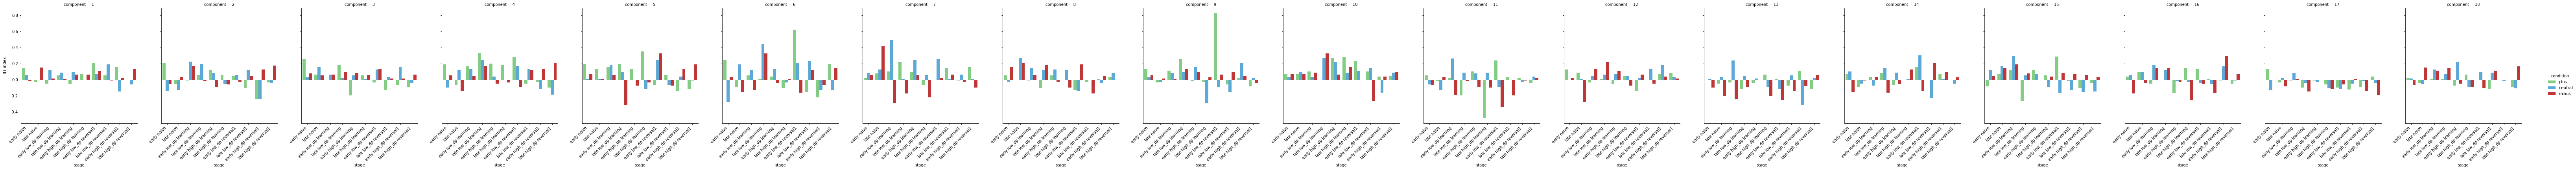

In [49]:
g = sns.catplot(data=df, col='component', y='TH_index', hue='condition', kind='bar', x='stage', palette=cas.lookups.color_dict)
g.set_xticklabels(rotation=45, ha='right')

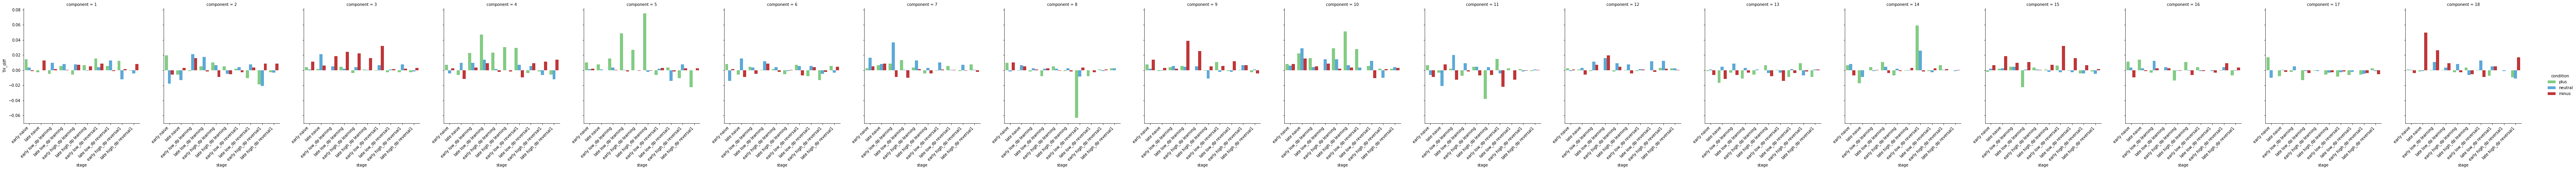

In [50]:
g = sns.catplot(data=df, col='component', y='TH_diff', hue='condition', kind='bar', x='stage', palette=cas.lookups.color_dict)
g.set_xticklabels(rotation=45, ha='right')

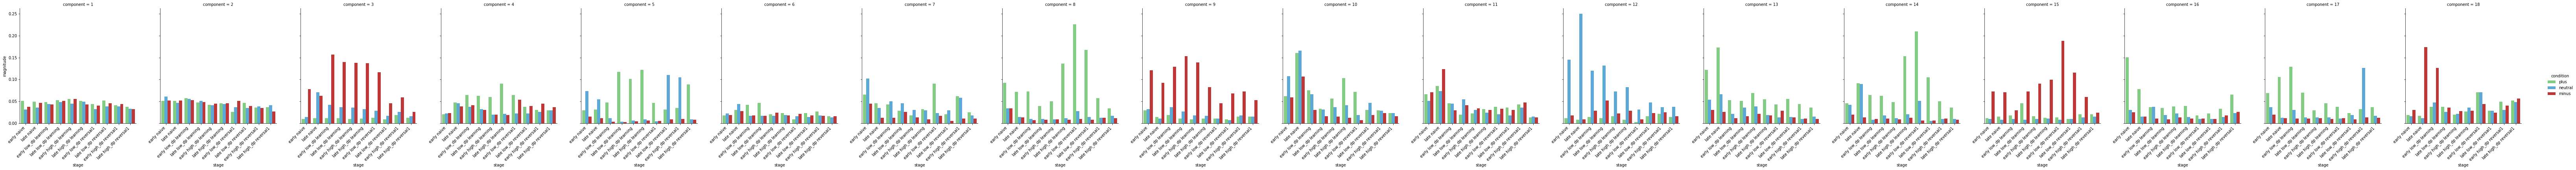

In [55]:
g = sns.catplot(data=df, col='component', y='magnitude', hue='condition', kind='bar', x='stage', palette=cas.lookups.color_dict)
g.set_xticklabels(rotation=45, ha='right')